In [1]:

import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RepeatedKFold, LeaveOneOut
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
import os
import sys

# Add project root to path (for Jupyter notebooks)
# Get the current directory and navigate to project root
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.insert(0, project_root)

from src.config import Config
import src.eda as eda
import src.present_value as present_value

%load_ext autoreload
%autoreload 2
%reload_ext autoreload


c:\Users\forer\anaconda3\envs\practicum\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
## FROM DATABASE
pv = present_value.PresentValue()
anual_increment = pv.fetch_incremento_from_database()

fase = "III"
preproccesing = eda.EDA()
df_raw = preproccesing.assemble_projects_from_database(fase)
df_vp = preproccesing.create_dataset(pv.present_value_costs, fase=fase)

c:\Code\Road-Project-Prediction\src\eda.py:286: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = (df[cols] / totals).fillna(0)


In [3]:
df = df_vp[df_vp['CÓDIGO'] != '0005']
df = df[['LONGITUD KM', 'ALCANCE']].join(df.loc[:, '1 - TRANSPORTE':'16 - DIRECCIÓN Y COORDINACIÓN'])
df

,LONGITUD KM,ALCANCE,1 - TRANSPORTE,2.1 - INFORMACIÓN GEOGRÁFICA,2.2 - TRAZADO Y DISEÑO GEOMÉTRICO,2.3 - SEGURIDAD VIAL,2.4 - SISTEMAS INTELIGENTES,3.1 - GEOLOGÍA,3.2 - HIDROGEOLOGÍA,4 - SUELOS,...,7 - SOCAVACIÓN,8 - ESTRUCTURAS,9 - TÚNELES,10 - URBANISMO Y PAISAJISMO,11 - PREDIAL,12 - IMPACTO AMBIENTAL,13 - CANTIDADES,14 - EVALUACIÓN SOCIOECONÓMICA,15 - OTROS - MANEJO DE REDES,16 - DIRECCIÓN Y COORDINACIÓN
0,17.400,Segunda calzada,0.000000e+00,0.000000e+00,1.353405e+08,7.287564e+07,4.013575e+07,1.239362e+08,0.000000e+00,1.878437e+08,...,5.275975e+07,6.838215e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.377238e+07,0.000000e+00,5.027965e+07,1.714043e+08
1,13.690,Nuevo,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.443049e+07,6.507553e+07,0.000000e+00,1.937793e+08,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.634289e+08
9,5.000,Mejoramiento,0.000000e+00,0.000000e+00,6.311029e+06,2.105373e+06,0.000000e+00,1.385817e+07,0.000000e+00,1.326106e+07,...,6.289853e+06,6.421774e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.901125e+07,6.672842e+06
10,2.500,Segunda calzada,0.000000e+00,0.000000e+00,1.814013e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.532367e+07,...,9.159642e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.250960e+07
11,17.000,Segunda calzada,0.000000e+00,0.000000e+00,8.023420e+07,1.158669e+07,0.000000e+00,4.968315e+07,0.000000e+00,1.308015e+08,...,4.467656e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.775515e+07
12,50.900,Mejoramiento,0.000000e+00,0.000000e+00,1.134648e+08,6.109646e+07,3.344233e+07,0.000000e+00,0.000000e+00,0.000000e+00,...,1.640687e+08,3.872771e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.132408e+07
13,9.000,Mejoramiento,0.000000e+00,0.000000e+00,2.006255e+07,1.080291e+07,5.913181e+06,0.000000e+00,0.000000e+00,0.000000e+00,...,2.901019e+07,6.847729e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.306812e+06
14,21.000,Mejoramiento,0.000000e+00,0.000000e+00,4.681261e+07,2.520679e+07,1.379742e+07,0.000000e+00,0.000000e+00,0.000000e+00,...,6.769043e+07,1.597804e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.704923e+07
15,14.000,Mejoramiento,0.000000e+00,0.000000e+00,3.120841e+07,1.680453e+07,9.198282e+06,0.000000e+00,0.000000e+00,0.000000e+00,...,4.512696e+07,1.065202e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.136615e+07
16,6.560,Mejoramiento,0.000000e+00,0.000000e+00,1.462337e+07,7.874121e+06,4.310052e+06,0.000000e+00,0.000000e+00,0.000000e+00,...,2.114520e+07,4.991234e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.325854e+06


In [4]:
def remove_outliers(df, target: str) -> pd.DataFrame:
    q1, q3 = df[target].quantile(0.05), df[target].quantile(0.95)
    iqr = q3 - q1
    x_clean = (df[target] >= q1 - 1.5*iqr) & (df[target] <= q3 + 1.5*iqr) & (df[target] != 0)
    
    df_clean = df[x_clean]
    return df_clean

In [5]:
def rmsle_scorer(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

def train_model(df_clean, predictor_name, hue_name, target_name):
    X = df_clean[[predictor_name, hue_name]].copy()
    X[predictor_name + ' LOG'] = np.log1p(X[predictor_name])
    y = df_clean[target_name].astype(float)

    pre = ColumnTransformer([
        ('num', StandardScaler(), [predictor_name, predictor_name + ' LOG']),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), [hue_name])
    ])

    svr = SVR(kernel='rbf')
    pipe = Pipeline([('pre', pre), ('svr', svr)])
    model = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)

    param_grid = {
        'regressor__svr__C': [5, 10, 80, 200, 1000],
        'regressor__svr__epsilon': [0.01],
        'regressor__svr__gamma': ['scale', 'auto', 0.01, 0.1, 1.0],
    }

    cv = RepeatedKFold(n_splits=min(5, len(y)//2), n_repeats=min(5, len(y)//2), random_state=42) if len(y) >= 10 else LeaveOneOut()
    gs = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, refit=True)
    gs.fit(X, y)

    from sklearn.model_selection import cross_val_predict
    cv_simple = RepeatedKFold(n_splits=min(5, len(y)//2), n_repeats=1, random_state=42) if len(y) >= 10 else LeaveOneOut()
    y_oof = cross_val_predict(gs.best_estimator_, X, y, cv=cv_simple, n_jobs=-1)
    
    r2_oof = r2_score(y, y_oof)
    mae_oof = mean_absolute_error(y, y_oof)
    rmse_oof = np.sqrt(mean_squared_error(y, y_oof))
    rmsle_oof = rmsle_scorer(y, y_oof)
    mape_oof = np.mean(np.abs((y - y_oof) / y.replace(0, np.nan))) * 100

    print('Best params:', gs.best_params_)
    print({'R2': r2_oof, 'MAE': mae_oof, 'RMSE': rmse_oof, 'RMSLE': rmsle_oof, 'MAPE%': float(mape_oof)})
    
    y_predicted = y_oof

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].scatter(y, y_predicted, alpha=0.6); lim = [y.min(), y.max()]
    ax[0].plot(lim, lim, 'r--'); ax[0].set_title('Actual vs Pred'); ax[0].set_xlabel('Actual'); ax[0].set_ylabel('Predicted')
    sns.histplot(y - y_predicted, kde=True, ax=ax[1], color='slateblue'); ax[1].set_title('Residuals')
    plt.tight_layout(); plt.show()
    
    return X, y, y_predicted 
    

Best params: {'regressor__svr__C': 5, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 0.01}
{'R2': 0.4457304096625694, 'MAE': 7050348.491619759, 'RMSE': np.float64(20332741.119893786), 'RMSLE': np.float64(0.4399299077186933), 'MAPE%': 27.080245202527877}


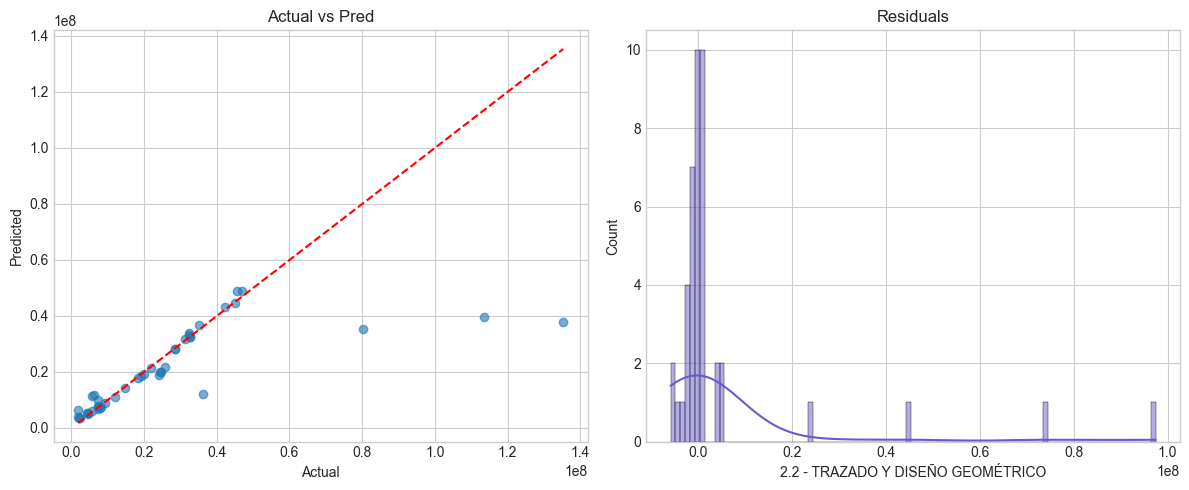

Best params: {'regressor__svr__C': 200, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 0.01}
{'R2': 0.5162606622734012, 'MAE': 4399671.420495005, 'RMSE': np.float64(10853626.055169614), 'RMSLE': np.float64(0.4512116370789251), 'MAPE%': 28.592146680317125}


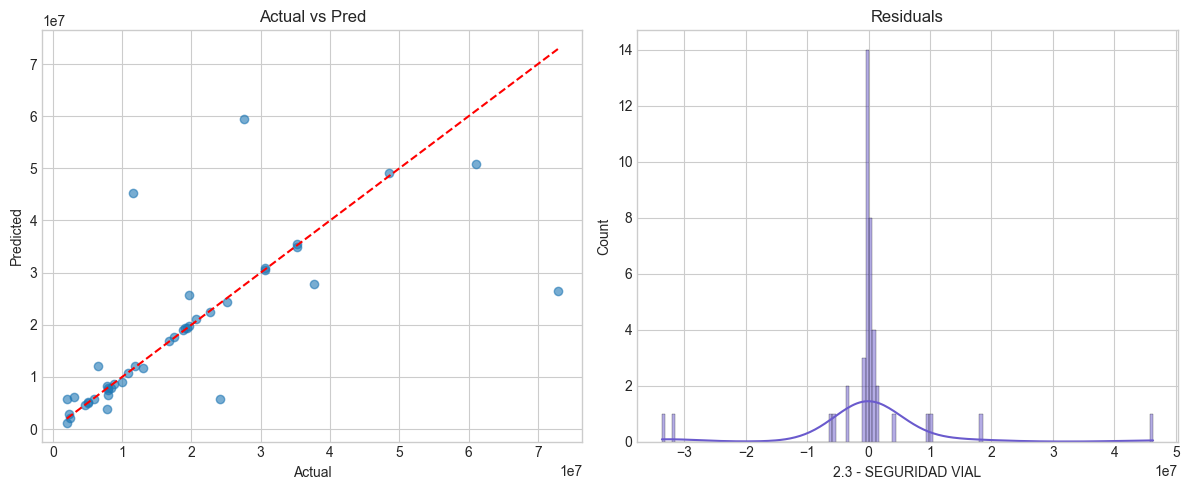

Best params: {'regressor__svr__C': 200, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 0.01}
{'R2': 0.6188714118468268, 'MAE': 2236704.5020523374, 'RMSE': np.float64(5979612.084273073), 'RMSLE': np.float64(0.2984005632391201), 'MAPE%': 11.579249245748336}


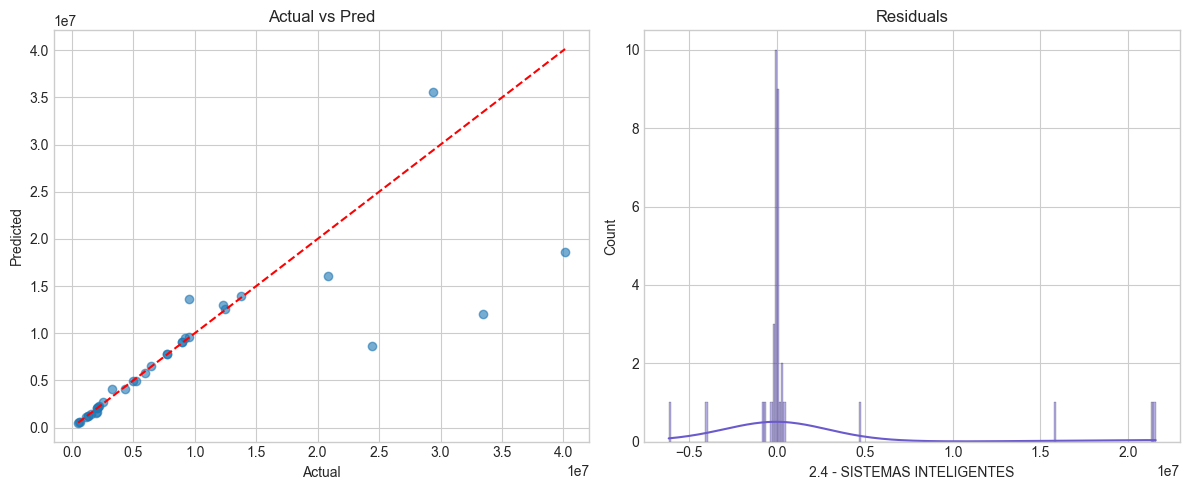

Best params: {'regressor__svr__C': 10, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 1.0}
{'R2': 0.48507459579099454, 'MAE': 9024409.525024517, 'RMSE': np.float64(17567713.264360145), 'RMSLE': np.float64(0.7441587372437732), 'MAPE%': 44.43521166384393}


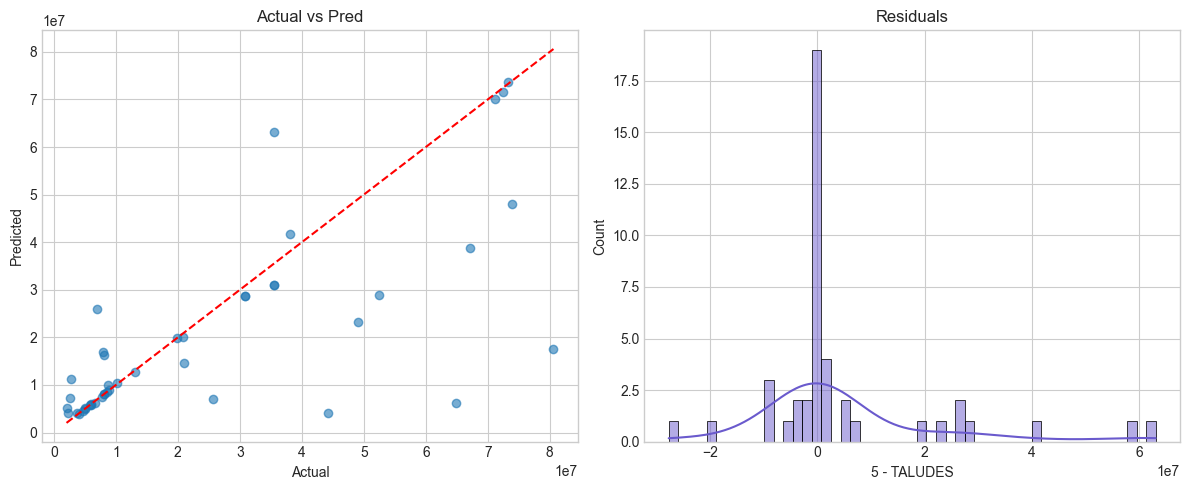

Best params: {'regressor__svr__C': 5, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 1.0}
{'R2': 0.4777131218607832, 'MAE': 6071770.331519033, 'RMSE': np.float64(11924484.685030235), 'RMSLE': np.float64(0.8441243571461229), 'MAPE%': 71.86659962277241}


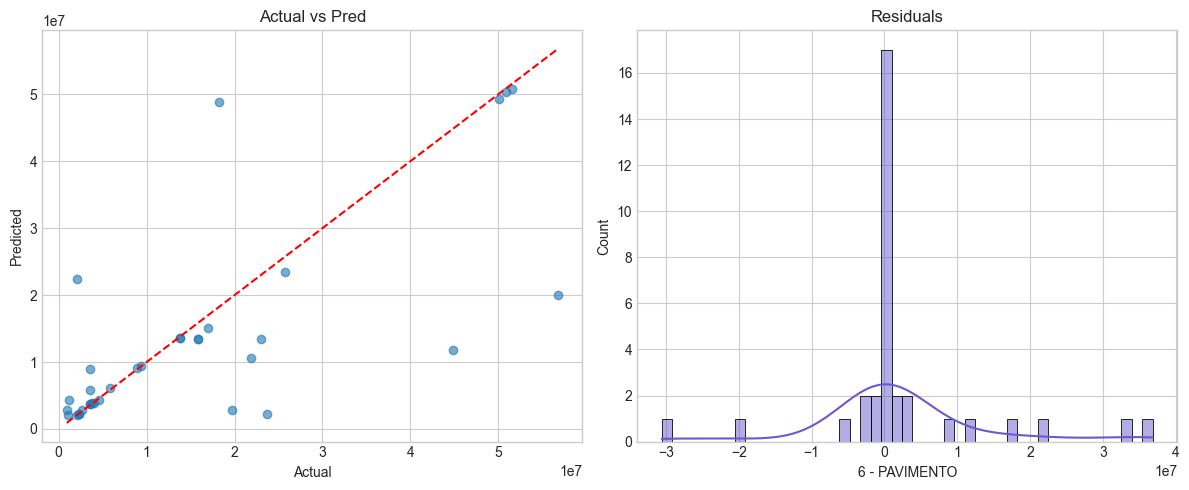

Best params: {'regressor__svr__C': 80, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 0.01}
{'R2': 0.9276855164711362, 'MAE': 4947870.326018341, 'RMSE': np.float64(8450648.822075218), 'RMSLE': np.float64(0.24720625037514848), 'MAPE%': 16.075167157375276}


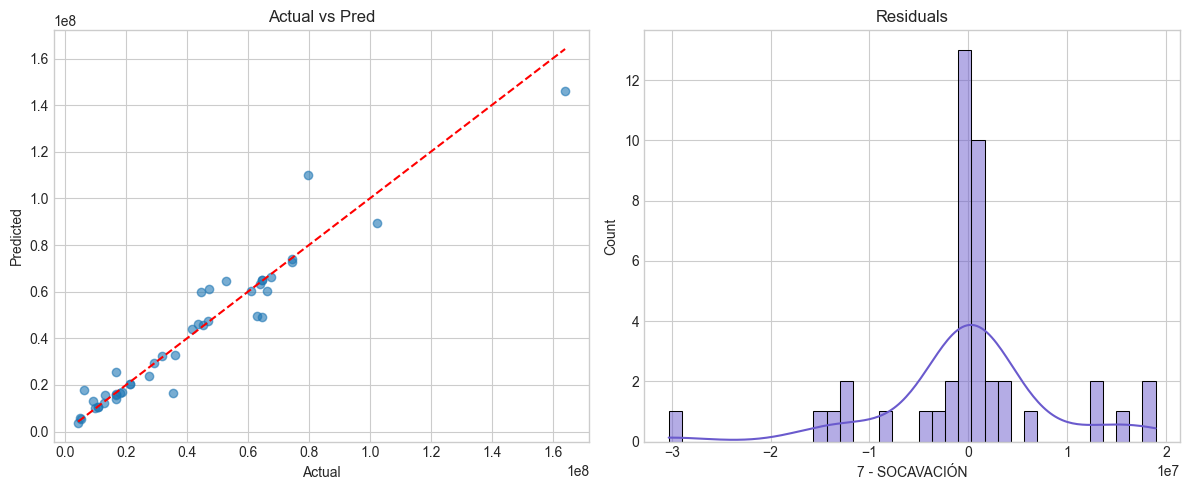

Best params: {'regressor__svr__C': 5, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 1.0}
{'R2': -0.4044402705078842, 'MAE': 710990.1232883679, 'RMSE': np.float64(1052513.0803657123), 'RMSLE': np.float64(0.059109258098428374), 'MAPE%': 3.8924951032041744}


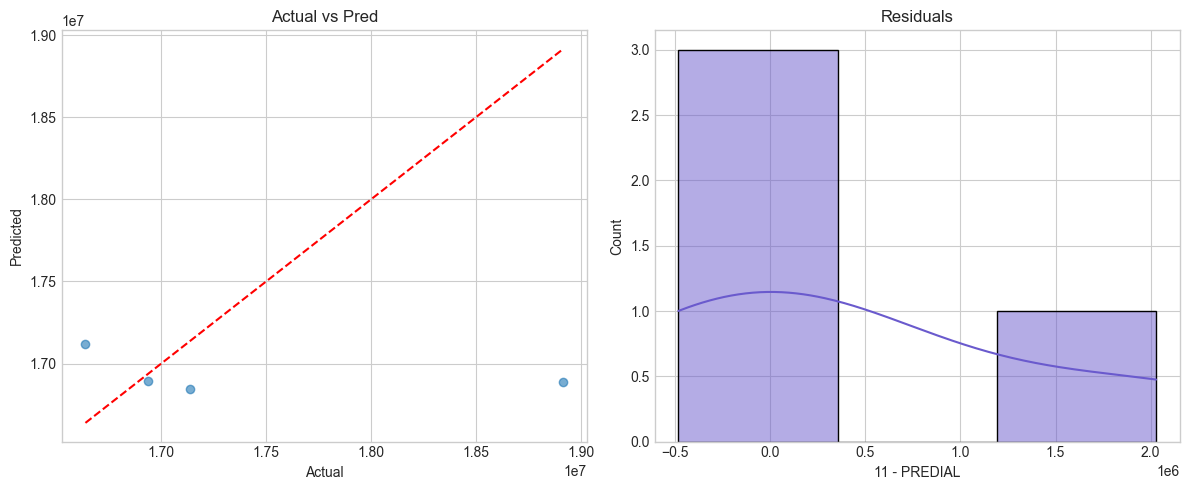

In [ ]:
def calculate_metrics(df, target_columns, predictor_name, hue_name):

    for target_name in target_columns:
        df_item = df.loc[:, [predictor_name, hue_name, target_name]]
        df_item_cleaned = remove_outliers(df_item, target_name)
        # preproccesing.show_plots_eda(predictor_name, target_name, hue_name, df_item_cleaned)
        X, y, y_predicted = train_model(df_item_cleaned, predictor_name, hue_name, target_name)
        if target_name == '11 - PREDIAL':
            break
    return X, y, y_predicted    

predictor_name = 'LONGITUD KM'
hue_name = 'ALCANCE'

# ['LONGITUD KM', 'ALCANCE', '1 - TRANSPORTE', '2.1 - INFORMACIÓN GEOGRÁFICA', '2.2 - TRAZADO Y DISEÑO GEOMÉTRICO',
#        '2.3 - SEGURIDAD VIAL', '2.4 - SISTEMAS INTELIGENTES', '3.1 - GEOLOGÍA','3.2 - HIDROGEOLOGÍA', '4 - SUELOS', '5 - TALUDES', '6 - PAVIMENTO',
#        '7 - SOCAVACIÓN', '8 - ESTRUCTURAS', '9 - TÚNELES', '10 - URBANISMO Y PAISAJISMO', '11 - PREDIAL', '12 - IMPACTO AMBIENTAL',
#        '13 - CANTIDADES', '14 - EVALUACIÓN SOCIOECONÓMICA', '15 - OTROS - MANEJO DE REDES', '16 - DIRECCIÓN Y COORDINACIÓN']

target_columns = ['2.2 - TRAZADO Y DISEÑO GEOMÉTRICO', '2.3 - SEGURIDAD VIAL', '2.4 - SISTEMAS INTELIGENTES', 
                  '5 - TALUDES', '6 - PAVIMENTO', '7 - SOCAVACIÓN', '11 - PREDIAL', 
                  '12 - IMPACTO AMBIENTAL', '15 - OTROS - MANEJO DE REDES', '16 - DIRECCIÓN Y COORDINACIÓN']

X, y, y_predicted = calculate_metrics(df, target_columns, predictor_name, hue_name)    

In [19]:
X['ACTUAL'] = y
X['PREDICTED'] = y_predicted
output = X.drop(columns=['LONGITUD KM LOG'])
output['difference'] = abs(X['ACTUAL'] - X['PREDICTED'])
output.sort_values(by='difference', ascending=False)

,LONGITUD KM,ALCANCE,ACTUAL,PREDICTED,difference
25,5.243,Mejoramiento,3.607640e+06,1.992742e+06,1.614897e+06
20,8.350,Rehabilitación,1.992742e+06,2.022203e+06,2.946064e+04
21,8.600,Rehabilitación,1.992742e+06,2.013353e+06,2.061008e+04
22,8.500,Rehabilitación,1.992742e+06,2.010114e+06,1.737118e+04
